In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.learner import *

import torchtext
from torchtext import vocab, data
from torchtext.datasets import language_modeling

from fastai.rnn_reg import *
from fastai.rnn_train import *
from fastai.nlp import *
from fastai.lm_rnn import *

import dill as pickle

from spooky import *

In [3]:
PATH = 'data/spooky'

os.makedirs(f'{PATH}/models', exist_ok=True)
os.makedirs(f'{PATH}/tmp', exist_ok=True)

bs = 64
bptt = 70

emb_sz = 200       # size of each embedding vector
nh = 500           # of hidden activations per layer
nl = 3             # of layers

# for NLP, configure Adam to use less momentum than the defaul of 0.9
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [4]:
# get raw training and test datasets
train_raw_df = pd.read_csv(f'{PATH}/train.csv')
test_df = pd.read_csv(f'{PATH}/test.csv')

len(train_raw_df), len(test_df)

(19579, 8392)

In [5]:
# build train and validation datasets
val_idxs = get_cv_idxs(len(train_raw_df))

train_df =  train_raw_df.drop(val_idxs)
val_df = train_raw_df.iloc[val_idxs]

len(train_df), len(val_df), len(test_df)

(15664, 3915, 8392)

In [6]:
# tokenize = split each sentence into a list of words
' '.join(spacy_tok(train_df.text.iloc[0]))

'It never once occurred to me that the fumbling might be a mere mistake .'

In [7]:
#createa torchtext field = describes how to preprocess a piece of text
TEXT = data.Field(lower=True, tokenize=spacy_tok)

In [8]:
FILES = dict(train_df=train_df, val_df=val_df, test_df=test_df)

# min_freq = 10 says, "treat any word that appears less than 10 times as the word <unk>"
md = LanguageModelData.from_dataframes(PATH, TEXT, 'text', **FILES, bs=bs, bptt=bptt, min_freq=10)

In [9]:
# after building the ModelData object, TEXT.vocab is set.  because this will be needed again, save it
pickle.dump(TEXT, open(f'{PATH}/models/TEXT.pkl', 'wb'))

In [10]:
# batches, # of unique tokens in vocab, # of items in ds, # of words in ds
len(md.trn_dl), md.nt, len(md.trn_ds), len(md.trn_ds[0].text)

(105, 4146, 1, 476141)

In [11]:
# int to string mapping
TEXT.vocab.itos[:12]

['<unk>', '<pad>', ',', 'the', 'of', '.', 'and', 'to', 'i', 'a', 'in', 'was']

In [12]:
# string to int mapping
TEXT.vocab.stoi['the']

3

In [13]:
# in a LanguageModelData object there is only one item in each dataset: all the words joined together
md.trn_ds[0].text[:12]

['it',
 'never',
 'once',
 'occurred',
 'to',
 'me',
 'that',
 'the',
 'fumbling',
 'might',
 'be',
 'a']

In [14]:
# torchtext will handle turning this words into integer Ids
TEXT.numericalize([md.trn_ds[0].text[:12]])

Variable containing:
   16
   98
  131
  826
    7
   27
   12
    3
    0
   88
   33
    9
[torch.cuda.LongTensor of size 12x1 (GPU 0)]

In [15]:
batch = next(iter(md.trn_dl))
print(batch[0].size()), print(batch[1].size())

batch

torch.Size([76, 64])
torch.Size([4864])


(Variable containing:
    16     2    25  ...     32   101     2
    98    29     3  ...    111     7    15
   131    62  1206  ...    286  3449     9
        ...          ⋱          ...       
   283   154     7  ...   1981    26     3
  2067    40    36  ...     63   297     0
     0    36     0  ...   4089    20     2
 [torch.cuda.LongTensor of size 76x64 (GPU 0)], Variable containing:
    98
    29
     3
   ⋮  
  1390
  3422
     6
 [torch.cuda.LongTensor of size 4864 (GPU 0)])

In [16]:
learner = md.get_model(opt_fn, emb_sz, nh, nl,
                      dropouti=0.1, dropout=0.1, wdrop=0.2, dropoute=0.04, dropouth=0.1)

learner.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learner.clip = 0.3

In [ ]:
lrf = learner.lr_find() 

In [ ]:
learner.sched.plot()

In [17]:
lr = 3e-3

In [18]:
learner.fit(lr, 4, wds=1e-6, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.62976  5.40083]                                
[ 1.       5.23407  4.98952]                                
[ 2.       5.01891  4.90852]                                
[ 3.       4.92566  4.77263]                                
[ 4.       4.79338  4.65923]                                
[ 5.       4.69406  4.6043 ]                                
[ 6.       4.64347  4.58921]                                
[ 7.       4.65033  4.54211]                                
[ 8.       4.56677  4.48592]                                
[ 9.       4.47929  4.43135]                                
[ 10.        4.4092    4.39944]                             
[ 11.        4.34232   4.38259]                             
[ 12.        4.28336   4.36738]                             
[ 13.        4.24418   4.36459]                             
[ 14.        4.23219   4.36396]                             



In [19]:
learner.save_encoder('spooky_adam1_enc')
# learner.load_encoder('spooky_adam1_enc')

In [20]:
learner.fit(lr, 1, wds=1e-6, cycle_len=5, cycle_save_name='spooky_adam2_c1_cl5')

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       4.31374  4.3738 ]                                
[ 1.       4.25343  4.35926]                                
[ 2.       4.1922   4.33831]                                
[ 3.       4.10928  4.33636]                                
[ 4.       4.08181  4.33935]                                



In [21]:
learner.save_encoder('spooky_adam2_enc')
# learner.load_encoder('spooky_adam2_enc')

In [22]:
learner.fit(lr, 2, wds=1e-6, cycle_len=2, cycle_save_name='spookey_adam3_2_2')

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

[ 0.       4.14504  4.33442]                                
[ 1.       4.0623   4.34103]                                
[ 2.       4.10453  4.33578]                               
[ 3.       4.01609  4.34206]                                



In [23]:
learner.save_encoder('spooky_adam3_enc')

In [24]:
learner.load_encoder('spooky_adam2_enc')

In [25]:
# metric perplexity (how language model accuracy generally measured) = exp() of loss functino
np.exp(4.33935)

76.657695638682966

In [ ]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True)

# get folds
kfolds = [ (train_idxs, val_idxs) for train_idxs, val_idxs in skf.split(train_df.id, train_df.author) ]
print(len(kfolds))

## Test

In [26]:
# create a short bit of text to "prime" the precitions, then use torchtext to numericalize it
# so we can feed it into our language model
m = learner.model
ss = """. It was a dark and scary night. The old"""
s = [spacy_tok(ss)]
t = TEXT.numericalize(s)
' '.join(s[0])

'. It was a dark and scary night . The old'

In [27]:
m[0].bs = 1      # set batch size = 1
m.eval()         # turn-off dropout
m.reset()        # reset hidden state
res, *_ = m(t)   # get predictions from model
m[0].bs = bs     # put batch size back to what it was

In [28]:
# top 10 predictions for next word
nexts = torch.topk(res[-1], 10)[1]
[TEXT.vocab.itos[o] for o in to_np(nexts)]

['<unk>', 'things', 'men', 'man', ',', 'and', 'people', 'old', 'whateley', "'"]

In [29]:
# try to generate more text
print(ss, "\n")

for i in range(50):
    n = res[-1].topk(2)[1]
    n = n[1] if n.data[0] == 0 else n[0]
    print(TEXT.vocab.itos[n.data[0]], end=' ')
    res, *_ = m(n[0].unsqueeze(0))
    
print('...')

. It was a dark and scary night. The old 

things , i have no longer to be the same . i was not in the same time that i had been a little more than a moment , and i was not sure that i had no longer known the place of the world . i was not in ...


## Predict the author

In [78]:
bs = 64
bptt = 70

emb_sz = 200       # size of each embedding vector
nh = 500           # of hidden activations per layer
nl = 3             # of layers

# for NLP, configure Adam to use less momentum than the defaul of 0.9
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [79]:
# use the same vocab built from the language model so as to ensure words map to same Ids
TEXT = pickle.load(open(f'{PATH}/models/TEXT.pkl', 'rb'))

In [80]:
AUTHOR_LABEL = data.Field(sequential=False)
splits = SpookyDataset.splits(TEXT, AUTHOR_LABEL, train_df, val_df, test_df)

In [81]:
t = splits[0].examples[0]

In [82]:
t.label, ' '.join(t.text[:10])

('HPL', 'it never once occurred to me that the fumbling might')

In [83]:
# fastai can create a ModelData object directly from torchtext splits
md2 = TextData.from_splits(PATH, splits, bs)

In [84]:
m3 = md2.get_model(opt_fn, 1500, bptt, emb_sz=emb_sz, n_hid=nh, n_layers=nl,
                      dropout=0.1, dropouti=0.4, wdrop=0.5, dropoute=0.05, dropouth=0.3)

m3.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
m3.load_encoder(f'spooky_adam2_enc')

In [85]:
m3.clip = 25.
lrs = np.array([1e-4, 1e-3, 1e-2])

In [86]:
m3.freeze_to(-1) # freeze everything except last layer
m3.fit(lrs/2, 2, metrics=[accuracy])

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

[ 0.       0.87729  0.84811  0.6022 ]                        
[ 1.       0.84941  0.78761  0.65907]                        



In [87]:
m3.unfreeze()
m3.fit(lrs, 2, metrics=[accuracy], cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

[ 0.       0.71044  0.64878  0.73156]                        
[ 1.       0.65291  0.58895  0.75615]                        



In [88]:
m3.fit(lrs/2, 4, metrics=[accuracy], cycle_len=1, cycle_mult=2, cycle_save_name='spooky_sent1_c4_cl1x2')

HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       0.60687  0.56309  0.77254]                        
[ 1.       0.59186  0.53384  0.78432]                        
[ 2.       0.56285  0.52658  0.7856 ]                        
[ 3.       0.54557  0.5176   0.79201]                        
[ 4.       0.52675  0.50809  0.79969]                        
[ 5.       0.49711  0.50258  0.79969]                        
[ 6.       0.46733  0.49642  0.8043 ]                        
[ 7.       0.48783  0.49819  0.80174]                        
[ 8.       0.4558   0.50583  0.79995]                        
[ 9.       0.45842  0.48785  0.81378]                        
[ 10.        0.40971   0.50226   0.80379]                    
[ 11.        0.39355   0.49745   0.81019]                    
[ 12.        0.37642   0.48217   0.8207 ]                    
[ 13.        0.35326   0.48325   0.81993]                    
[ 14.        0.35065   0.48316   0.81967]                    



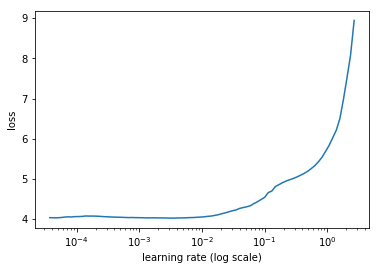

In [54]:
learner.lr_find()
learner.sched.plot()

In [89]:
m3.fit(lrs/4, 1, metrics=[accuracy], cycle_len=5, cycle_save_name='spooky_sent2_c1_cl5')

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       0.36546  0.51     0.80815]                        
[ 1.       0.34893  0.48796  0.82198]                        
[ 2.       0.33975  0.49133  0.81967]                        
[ 3.       0.33981  0.49078  0.81967]                        
[ 4.       0.34309  0.48492  0.82198]                        



In [90]:
m3.fit(lrs/4, 1, metrics=[accuracy], cycle_len=10, cycle_save_name='spooky_sent2_c1_cl10')

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

[ 0.       0.32271  0.50567  0.81762]                        
[ 1.       0.34265  0.48839  0.82172]                        
[ 2.       0.3314   0.48155  0.82198]                        
[ 3.       0.32549  0.4927   0.82044]                        
[ 4.       0.3187   0.48662  0.823  ]                        
[ 5.       0.2862   0.51534  0.81583]                        
[ 6.       0.303    0.49634  0.82095]                        
[ 7.       0.29647  0.49463  0.82121]                        
[ 8.       0.28445  0.49597  0.82198]                        
[ 9.       0.25804  0.49594  0.82147]                        



In [91]:
m3.load_cycle('spooky_sent2_c1_cl5', 0)
# m3

In [92]:
classes = AUTHOR_LABEL.vocab.itos
classes

['<unk>', 'EAP', 'MWS', 'HPL']

In [93]:
preds = []

m = m3.model 
m[0].bs = 1
for index, row in test_df.iterrows():
    ss = row['text']
    s = [spacy_tok(ss)]
    t = TEXT.numericalize(s)
   
    m.eval()
    m.reset()
    res,*_ = m(t)
    preds.append(to_np(res).squeeze()[1:])
#     preds.append(to_np(res).squeeze())
    
preds = np.array(preds)
preds.shape

(8392, 3)

In [94]:
probs = to_np(F.softmax(torch.from_numpy(preds)))

In [95]:
probs.shape

(8392, 3)

In [96]:
preds_test_df = test_df.copy()
preds_test_df['EAP'] = probs[:,0]
preds_test_df['MWS'] = probs[:,1]
preds_test_df['HPL'] = probs[:,2]

preds_test_df.drop('text', axis=1, inplace=True)
preds_test_df.head()

,id,EAP,MWS,HPL
0,id02310,0.007532,0.964385,0.028083
1,id24541,0.999075,0.000702,0.000223
2,id00134,0.000099,0.000756,0.999145
3,id27757,0.783808,0.174231,0.041961
4,id04081,0.333220,0.127608,0.539172


In [97]:
preds_test_df.to_csv(f'{PATH}/subm_wg_20171126_3.csv', index=None)

In [77]:
preds_test_df.dtypes

id      object
EAP    float32
MWS    float32
HPL    float32
dtype: object